<a href="https://colab.research.google.com/github/SamGrievo/Time-Series-Forecasting/blob/main/Many_to_one_Bike_Data_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing as skp
import torch
import sklearn.metrics as skm
import sklearn.preprocessing as skp
from torch.autograd import Variable
import time

In [ ]:
df = pd.read_csv('/content/london_merged.csv')

In [ ]:
bike_data_df = df.dropna()
index = bike_data_df.timestamp.astype('datetime64[ns]')
bike_data = bike_data_df.set_index(pd.to_datetime(index))

In [ ]:
bike_data = bike_data.drop(columns=['timestamp'])

In [ ]:
bike_data.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [ ]:
bike_data_ = bike_data[11000:]
print(len(bike_data_))

6414


In [ ]:
bike_data_['season'].value_counts(ascending=False)

1.0    2186
2.0    2145
0.0    1267
3.0     816
Name: season, dtype: int64

In [ ]:
bike_data_['is_holiday'].value_counts(ascending=False)

0.0    6270
1.0     144
Name: is_holiday, dtype: int64

In [ ]:
bike_data_['is_weekend'].value_counts(ascending=False)

0.0    4562
1.0    1852
Name: is_weekend, dtype: int64

In [ ]:
bike_data_['weather_code'].value_counts(ascending=False)

1.0     2439
2.0     1464
3.0     1203
7.0      672
4.0      619
26.0       9
10.0       8
Name: weather_code, dtype: int64

In [ ]:
bike_data_ = bike_data_[bike_data_.weather_code != 26.0]
bike_data_ = bike_data_[bike_data_.weather_code != 10.0]

In [ ]:
bike_data_['weather_code'].value_counts(ascending=False)

1.0    2439
2.0    1464
3.0    1203
7.0     672
4.0     619
Name: weather_code, dtype: int64

In [ ]:
bike_data_ = bike_data_.drop(columns=['season','weather_code','is_holiday'])

In [ ]:
bike_data_.head()


,cnt,t1,t2,hum,wind_speed,is_weekend
timestamp,,,,,,
2016-04-09 05:00:00,57,8.5,5.5,84.5,17.0,1.0
2016-04-09 06:00:00,119,8.0,5.0,87.0,18.5,1.0
2016-04-09 07:00:00,128,8.0,5.0,90.0,16.0,1.0
2016-04-09 08:00:00,246,8.0,5.5,90.0,15.0,1.0
2016-04-09 09:00:00,563,8.0,6.0,87.0,9.0,1.0


In [ ]:
# encoder = skp.OneHotEncoder()

# bike_data_encode_season = encoder.fit_transform(bike_data_['season'].values.reshape(-1,1))
# df = pd.DataFrame(bike_data_encode_season.toarray())

# bike_data_ = pd.concat([bike_data_.drop(columns='season'), df])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7b67816250>,
      dtype=object)

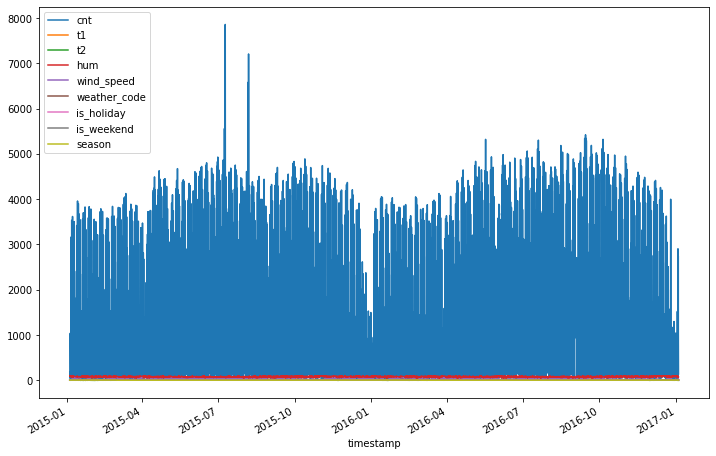

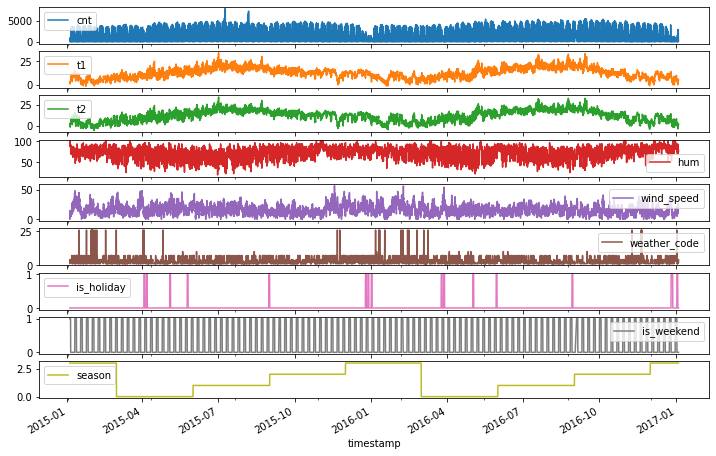

In [ ]:
bike_data.plot(figsize=(12,8))
bike_data.plot(subplots=True, figsize = (12,8))


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7b66edc090>,
      dtype=object)

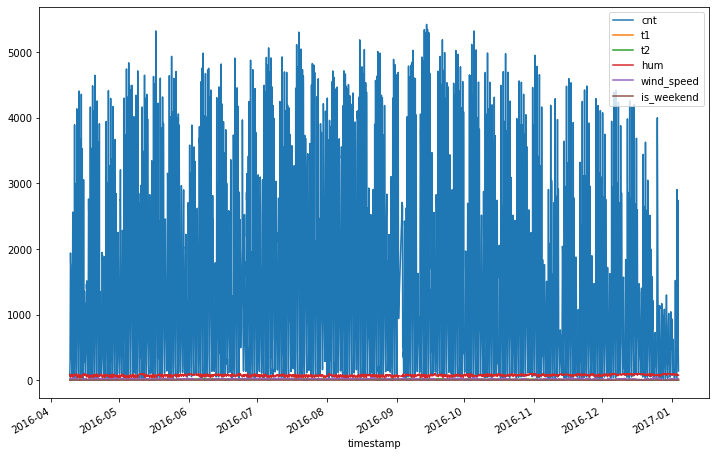

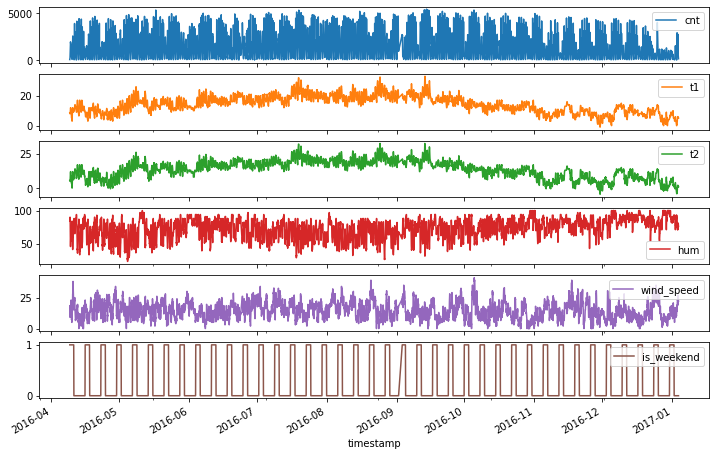

In [ ]:
bike_data_.plot(figsize=(12,8))
bike_data_.plot(subplots=True, figsize=(12,8))

In [ ]:
def sliding_window(dataset, window):

  x = []
  y = []

  for i in range(len(dataset)-window):

    _x = dataset[i:i+window]
    _y = dataset[i+window]

    x.append(_x)
    y.append(_y)

  return np.array(x),np.array(y)


In [ ]:
scaler = skp.MinMaxScaler()
x_vals_scaled = scaler.fit_transform(bike_data_.values)
#window size of a week
window = 24

x, y = sliding_window(x_vals_scaled, window)
y = y[:,1]
y=np.array(y)[:,np.newaxis]
y.shape


(6373, 1)

In [ ]:
def split_dataloader(x,y,train_start,train_end,train_size,val_start,val_end,val_size,test_start,test_end,test_size):

  train_x = Variable(torch.Tensor(np.array(x[train_start:train_end])))
  train_y = Variable(torch.Tensor(np.array(y[train_start:train_end])))

  train_dataset = torch.utils.data.TensorDataset(train_x, train_y)
  trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=train_size)

  val_x = Variable(torch.Tensor(np.array(x[val_start:val_end])))
  val_y = Variable(torch.Tensor(np.array(y[val_start:val_end])))  

  val_dataset = torch.utils.data.TensorDataset(val_x, val_y)
  valloader = torch.utils.data.DataLoader(val_dataset, batch_size=val_size)

  test_x = Variable(torch.Tensor(np.array(x[test_start:test_end])))
  test_y = Variable(torch.Tensor(np.array(y[test_start:test_end])))

  test_dataset = torch.utils.data.TensorDataset(test_x, test_y)
  testloader = torch.utils.data.DataLoader(test_dataset, batch_size=test_size)

  return trainloader, valloader, testloader

In [ ]:
train_size = int(len(y) * 0.90)
val_size = int(train_size+(len(y)*0.05))
test_size = int(val_size+(len(y)*0.05))

trainloader, valloader, testloader = split_dataloader(x,y,0,train_size,train_size+1,train_size,val_size,val_size+1,val_size,test_size,test_size)

#these are not the sizes of each set but rather the index numbers which represent when each set ends.
print(train_size,val_size,test_size)

data_batch, target_batch = next(iter(trainloader))
print(data_batch.size())
print(target_batch.size())
print('Training Window:', data_batch[0], data_batch.size(0))
print('Target:', target_batch[0])

val_data_batch, val_target_batch = next(iter(valloader))
print(val_data_batch.size())
print(val_target_batch.size())
print('Training Window:', val_data_batch[0])
print('Target:', val_target_batch[0])

test_data_batch, test_target_batch = next(iter(testloader))
print('test',test_data_batch.size())
print('test',test_target_batch.size())
print('Training Window:', test_data_batch[1],)
print('Target:', test_target_batch[1])

5735 6053 6371
torch.Size([5735, 24, 6])
torch.Size([5735, 1])
Training Window: tensor([[0.0089, 0.2794, 0.2703, 0.7987, 0.4146, 1.0000],
        [0.0203, 0.2647, 0.2568, 0.8312, 0.4512, 1.0000],
        [0.0220, 0.2647, 0.2568, 0.8701, 0.3902, 1.0000],
        [0.0438, 0.2647, 0.2703, 0.8701, 0.3659, 1.0000],
        [0.1023, 0.2647, 0.2838, 0.8312, 0.2195, 1.0000],
        [0.1886, 0.2941, 0.3108, 0.7273, 0.3659, 1.0000],
        [0.2509, 0.3382, 0.3784, 0.4870, 0.4146, 1.0000],
        [0.3120, 0.3529, 0.4189, 0.3831, 0.3659, 1.0000],
        [0.3564, 0.3676, 0.4324, 0.2922, 0.3171, 1.0000],
        [0.3296, 0.3824, 0.4459, 0.3636, 0.3659, 1.0000],
        [0.3272, 0.3529, 0.4189, 0.4545, 0.5000, 1.0000],
        [0.3233, 0.3382, 0.3649, 0.4545, 0.5122, 1.0000],
        [0.3072, 0.3235, 0.3243, 0.5390, 0.4268, 1.0000],
        [0.2634, 0.3382, 0.3649, 0.4026, 0.5610, 1.0000],
        [0.1945, 0.3088, 0.2973, 0.4545, 0.5610, 1.0000],
        [0.1278, 0.2647, 0.2432, 0.4740, 0.5000, 1

In [ ]:
class LSTM(torch.nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        #num_classes = output dimension, num_layers = amount of LSTM layers stacked, input_size = input data dimension (window size), hidden_size = hidden neurons per layer.
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = window
        #PyTorch LSTM module
        self.lstm = torch.nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        #PyTorch linear layer for output
        self.fc = torch.nn.Linear(hidden_size, num_classes)
    #forward pass of cell and hidden state according to PyTorch documentation
    def forward(self, x):
      #hidden state output
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        #cell output
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        
        
        out = self.fc(h_out[0])
        
        return out


In [ ]:
input_size = 6
hidden_size = 40
num_layers = 1
output_size = 1

lstm_model = LSTM(output_size, input_size, hidden_size, num_layers)
loss = torch.nn.MSELoss()
optim = torch.optim.Adam(lstm_model.parameters(), lr=0.01)
print(lstm_model)

LSTM(
  (lstm): LSTM(6, 40, batch_first=True)
  (fc): Linear(in_features=40, out_features=1, bias=True)
)


In [ ]:
epochs = 30
train_loss = []
val_loss = []

start = time.time()
for i in range(epochs):
  lstm_model.train()
  epoch_loss = 0.0
  for x,y in trainloader:
    
    optim.zero_grad()  

    y_pred = lstm_model(x)
    print(y_pred.shape)
    single_loss = loss(y_pred, y)
    single_loss.backward()
    optim.step()

    epoch_loss += single_loss.item()
    train_loss.append(single_loss.item())

    if i%25 == 1:
        print(f'epoch: {i:3} train loss: {single_loss.item():10.8f}')

  lstm_model.eval()
  for x,y in valloader:

    optim.zero_grad()  

    y_pred = lstm_model(x)

    single_loss = loss(y_pred, y)
    single_loss.backward()
    optim.step()

    val_loss.append(single_loss.item())

    if i%25 == 1:
        print(f'epoch: {i:3}validation loss: {single_loss.item():10.8f}')

end = time.time()

torch.Size([5735, 1])
torch.Size([5735, 1])
epoch:   1 train loss: 0.02022874
epoch:   1validation loss: 0.15812021
torch.Size([5735, 1])
torch.Size([5735, 1])
torch.Size([5735, 1])
torch.Size([5735, 1])
torch.Size([5735, 1])
torch.Size([5735, 1])
torch.Size([5735, 1])
torch.Size([5735, 1])
torch.Size([5735, 1])
torch.Size([5735, 1])
torch.Size([5735, 1])
torch.Size([5735, 1])
torch.Size([5735, 1])
torch.Size([5735, 1])
torch.Size([5735, 1])
torch.Size([5735, 1])
torch.Size([5735, 1])
torch.Size([5735, 1])
torch.Size([5735, 1])
torch.Size([5735, 1])
torch.Size([5735, 1])
torch.Size([5735, 1])
torch.Size([5735, 1])
torch.Size([5735, 1])
torch.Size([5735, 1])
epoch:  26 train loss: 0.00618356
epoch:  26validation loss: 0.00143555
torch.Size([5735, 1])
torch.Size([5735, 1])
torch.Size([5735, 1])


[0.18031276762485504, 0.020228739827871323, 0.02365606464445591, 0.03678680956363678, 0.05963347479701042, 0.060651011765003204, 0.049548614770174026, 0.03522495552897453, 0.02324199676513672, 0.01679091714322567, 0.01519001554697752, 0.014696977101266384, 0.014499863609671593, 0.01578332670032978, 0.018069148063659668, 0.019852688536047935, 0.019991129636764526, 0.01822449080646038, 0.015143372118473053, 0.01186145655810833, 0.00942179374396801, 0.008071999065577984, 0.007248370908200741, 0.006782022304832935, 0.006811181548982859, 0.006359128747135401, 0.006183559540659189, 0.006688142195343971, 0.00543464720249176, 0.004928935319185257]


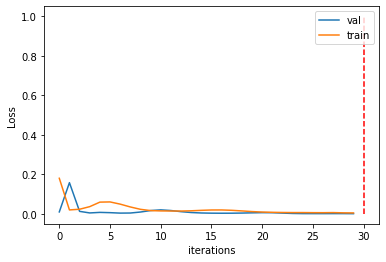

In [ ]:
print(train_loss)
fig, ax = plt.subplots()
ax.plot(val_loss,label="val")
ax.plot(train_loss,label="train")
ax.vlines(30, 0, 1, linestyles='dashed', colors='red')
plt.xlabel("iterations")
plt.ylabel("Loss")

plt.legend()
plt.show()

In [ ]:
lstm_model.eval()
for x_test,y_test in testloader:
  y_test_pred = lstm_model(x_test)
  
print(y_test_pred.shape)


torch.Size([318, 1])


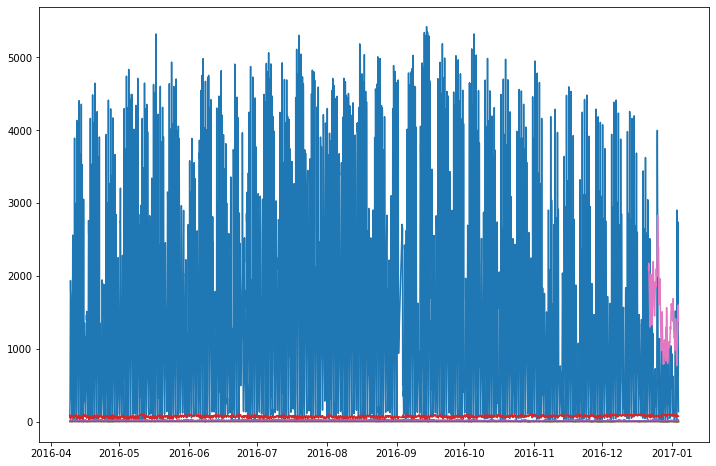

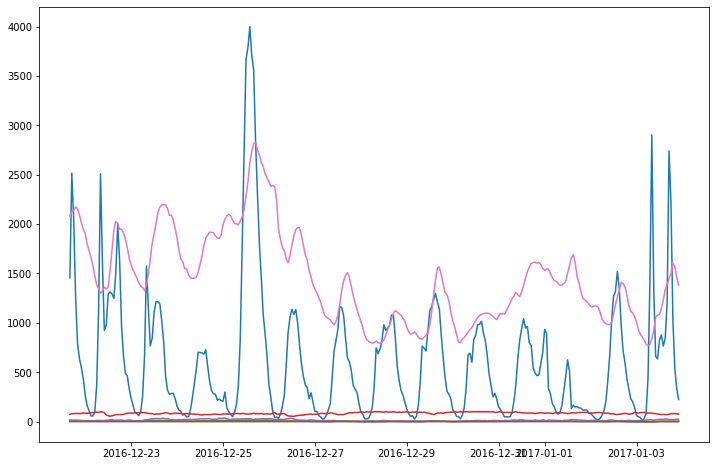

Mean squared error for 24 forecast steps: 1056.7662365817425
Mean absolute percentage error for 24 forecast steps: 7.0203600106792905


In [ ]:
data_predict = y_test_pred.data.numpy()
data_predict.shape


bike_data_scaler = bike_data_['cnt']
test_bike_data = np.array(bike_data_scaler)[:, np.newaxis]
descaler = skp.MinMaxScaler()
test_vals_scaled = descaler.fit_transform(test_bike_data)
predictions_rescaled = descaler.inverse_transform(data_predict)


df = pd.DataFrame(predictions_rescaled, index=bike_data_.index[6054+24:6054+318+24])

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(bike_data_)
ax.plot(df)
plt.show()

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(bike_data_.index[6054+24:6054+318+24], bike_data_.values[6054+24:6054+318+24])
plt.plot(df)
plt.show()

test_rescaled = test_bike_data[6054+24:6054+318+24]

rmse = skm.mean_squared_error(test_rescaled, predictions_rescaled, squared=False)
print("Mean squared error for 24 forecast steps:", rmse)
mape = skm.mean_absolute_percentage_error(test_rescaled, predictions_rescaled)
print("Mean absolute percentage error for 24 forecast steps:", mape)

2nd Dataset variation

In [ ]:
bike_data_2nd = bike_data[11000:]

In [ ]:
bike_data_2nd.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2016-04-09 05:00:00,57,8.5,5.5,84.5,17.0,7.0,0.0,1.0,0.0
2016-04-09 06:00:00,119,8.0,5.0,87.0,18.5,4.0,0.0,1.0,0.0
2016-04-09 07:00:00,128,8.0,5.0,90.0,16.0,7.0,0.0,1.0,0.0
2016-04-09 08:00:00,246,8.0,5.5,90.0,15.0,7.0,0.0,1.0,0.0
2016-04-09 09:00:00,563,8.0,6.0,87.0,9.0,3.0,0.0,1.0,0.0


In [ ]:

bike_data_2nd = bike_data_2nd.drop(columns=['weather_code','is_holiday','season','is_weekend','t2','hum'])

In [ ]:
bike_data_2nd.head()

,cnt,t1,wind_speed
timestamp,,,
2016-04-09 05:00:00,57,8.5,17.0
2016-04-09 06:00:00,119,8.0,18.5
2016-04-09 07:00:00,128,8.0,16.0
2016-04-09 08:00:00,246,8.0,15.0
2016-04-09 09:00:00,563,8.0,9.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7b66e36710>,
      dtype=object)

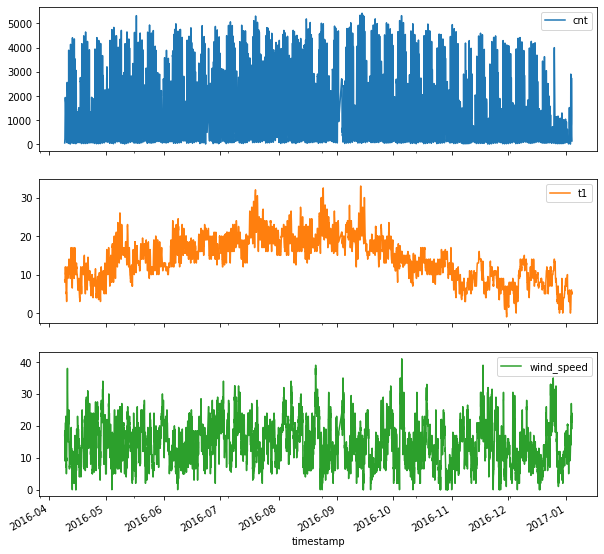

In [ ]:
bike_data_2nd.plot(subplots = True, figsize=(10,10)) 

In [ ]:
scaler = skp.MinMaxScaler()
x_vals_scaled_2nd = scaler.fit_transform(bike_data_2nd.values)
#window size of a week
window = 24

x_2nd, y_2nd = sliding_window(x_vals_scaled_2nd, window)
y_2nd = y_2nd[:,1]
y_2nd=np.array(y_2nd)[:,np.newaxis]
y_2nd.shape

(6390, 1)

In [ ]:
trainloader_2nd, valloader_2nd, testloader_2nd = split_dataloader(x_2nd,y_2nd,0,train_size,train_size+1,train_size,val_size,val_size+1,val_size,test_size,test_size)

data_batch, target_batch = next(iter(trainloader_2nd))
print(data_batch.size())
print(target_batch.size())
print('Training Window:', data_batch[0], data_batch.size(0))
print('Target:', target_batch[0])

val_data_batch, val_target_batch = next(iter(valloader_2nd))
print(val_data_batch.size())
print(val_target_batch.size())
print('Training Window:', val_data_batch[0])
print('Target:', val_target_batch[0])

test_data_batch, test_target_batch = next(iter(testloader_2nd))
print('test',test_data_batch.size())
print('test',test_target_batch.size())
print('Training Window:', test_data_batch[1],)
print('Target:', test_target_batch[1])

torch.Size([5735, 24, 3])
torch.Size([5735, 1])
Training Window: tensor([[0.0089, 0.2794, 0.4146],
        [0.0203, 0.2647, 0.4512],
        [0.0220, 0.2647, 0.3902],
        [0.0438, 0.2647, 0.3659],
        [0.1023, 0.2647, 0.2195],
        [0.1886, 0.2941, 0.3659],
        [0.2509, 0.3382, 0.4146],
        [0.3120, 0.3529, 0.3659],
        [0.3564, 0.3676, 0.3171],
        [0.3296, 0.3824, 0.3659],
        [0.3272, 0.3529, 0.5000],
        [0.3233, 0.3382, 0.5122],
        [0.3072, 0.3235, 0.4268],
        [0.2634, 0.3382, 0.5610],
        [0.1945, 0.3088, 0.5610],
        [0.1278, 0.2647, 0.5000],
        [0.0844, 0.2353, 0.3415],
        [0.0735, 0.2353, 0.2683],
        [0.0752, 0.2059, 0.2195],
        [0.0647, 0.1912, 0.1707],
        [0.0562, 0.1765, 0.1951],
        [0.0331, 0.1912, 0.1951],
        [0.0329, 0.1765, 0.1220],
        [0.0181, 0.1324, 0.2195]]) 5735
Target: tensor([0.1324])
torch.Size([318, 24, 3])
torch.Size([318, 1])
Training Window: tensor([[0.5585, 0.3382, 

In [ ]:
class LSTM(torch.nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        #num_classes = output dimension, num_layers = amount of LSTM layers stacked, input_size = input data dimension (window size), hidden_size = hidden neurons per layer.
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = window
        #PyTorch LSTM module
        self.lstm = torch.nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        #PyTorch linear layer for output
        self.fc = torch.nn.Linear(hidden_size, num_classes)
    #forward pass of cell and hidden state according to PyTorch documentation
    def forward(self, x):
      #hidden state output
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        #cell output
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        
        
        out = self.fc(h_out[0])
        
        return out

In [ ]:
input_size = 3
hidden_size = 40
num_layers = 1
output_size = 1

lstm_model = LSTM(output_size, input_size, hidden_size, num_layers)
loss = torch.nn.MSELoss()
optim = torch.optim.Adam(lstm_model.parameters(), lr=0.01)
print(lstm_model)

LSTM(
  (lstm): LSTM(3, 40, batch_first=True)
  (fc): Linear(in_features=40, out_features=1, bias=True)
)


In [ ]:
epochs = 30
train_loss = []
val_loss = []

start = time.time()
for i in range(epochs):
  lstm_model.train()
  epoch_loss = 0.0
  for x,y in trainloader_2nd:
    
    optim.zero_grad()  

    y_pred = lstm_model(x)
    print(y_pred.shape)
    single_loss = loss(y_pred, y)
    single_loss.backward()
    optim.step()

    epoch_loss += single_loss.item()
    train_loss.append(single_loss.item())

    if i%25 == 1:
        print(f'epoch: {i:3} train loss: {single_loss.item():10.8f}')

  lstm_model.eval()
  for x,y in valloader_2nd:

    optim.zero_grad()  

    y_pred = lstm_model(x)

    single_loss = loss(y_pred, y)
    single_loss.backward()
    optim.step()

    val_loss.append(single_loss.item())

    if i%25 == 1:
        print(f'epoch: {i:3}validation loss: {single_loss.item():10.8f}')

end = time.time()

torch.Size([5735, 1])
torch.Size([5735, 1])
epoch:   1 train loss: 0.06138150
epoch:   1validation loss: 0.04187182
torch.Size([5735, 1])
torch.Size([5735, 1])
torch.Size([5735, 1])
torch.Size([5735, 1])
torch.Size([5735, 1])
torch.Size([5735, 1])
torch.Size([5735, 1])
torch.Size([5735, 1])
torch.Size([5735, 1])
torch.Size([5735, 1])
torch.Size([5735, 1])
torch.Size([5735, 1])
torch.Size([5735, 1])
torch.Size([5735, 1])
torch.Size([5735, 1])
torch.Size([5735, 1])
torch.Size([5735, 1])
torch.Size([5735, 1])
torch.Size([5735, 1])
torch.Size([5735, 1])
torch.Size([5735, 1])
torch.Size([5735, 1])
torch.Size([5735, 1])
torch.Size([5735, 1])
torch.Size([5735, 1])
epoch:  26 train loss: 0.00402063
epoch:  26validation loss: 0.00141619
torch.Size([5735, 1])
torch.Size([5735, 1])
torch.Size([5735, 1])


[0.28751063346862793, 0.061381496489048004, 0.019758837297558784, 0.02230764366686344, 0.03285423666238785, 0.032621581107378006, 0.025249216705560684, 0.018369238823652267, 0.015508543699979782, 0.014898490160703659, 0.015729116275906563, 0.018087979406118393, 0.019702043384313583, 0.0184861421585083, 0.015023662708699703, 0.011781532317399979, 0.010129441507160664, 0.009662596508860588, 0.010134716518223286, 0.008986659348011017, 0.005653201136738062, 0.004797150380909443, 0.005032441578805447, 0.010236714966595173, 0.005964495707303286, 0.003895803587511182, 0.004020626191049814, 0.005547070875763893, 0.005524692591279745, 0.003935415763407946]


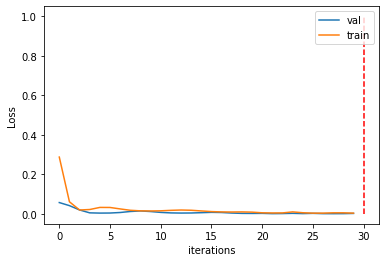

In [ ]:
print(train_loss)
fig, ax = plt.subplots()
ax.plot(val_loss,label="val")
ax.plot(train_loss,label="train")
ax.vlines(30, 0, 1, linestyles='dashed', colors='red')
plt.xlabel("iterations")
plt.ylabel("Loss")

plt.legend()
plt.show()

In [ ]:
lstm_model.eval()
for x_test,y_test in testloader_2nd:
  y_test_pred = lstm_model(x_test)
  
print(y_test_pred.shape)

torch.Size([318, 1])


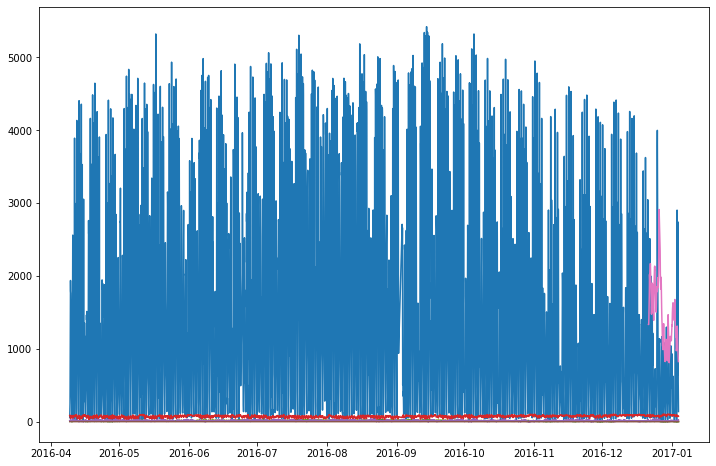

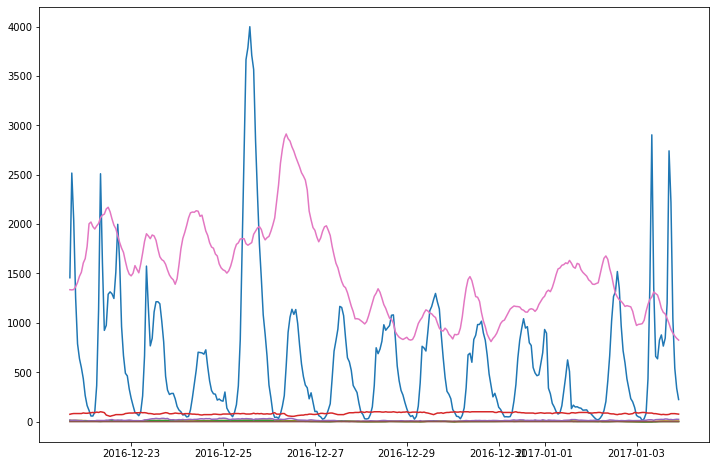

Mean squared error for 24 forecast steps: 1152.9921264347352
Mean absolute percentage error for 24 forecast steps: 7.928127315786727


In [ ]:
data_predict = y_test_pred.data.numpy()
data_predict.shape


bike_data_scaler = bike_data_['cnt']
test_bike_data = np.array(bike_data_scaler)[:, np.newaxis]
descaler = skp.MinMaxScaler()
test_vals_scaled = descaler.fit_transform(test_bike_data)
predictions_rescaled = descaler.inverse_transform(data_predict)


df = pd.DataFrame(predictions_rescaled, index=bike_data_.index[6054+24:6054+318+24])

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(bike_data_)
ax.plot(df)
plt.show()

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(bike_data_.index[6054+24:6054+318+24], bike_data_.values[6054+24:6054+318+24])
plt.plot(df)
plt.show()

test_rescaled = test_bike_data[6054+24:6054+318+24]

rmse = skm.mean_squared_error(test_rescaled, predictions_rescaled, squared=False)
print("Mean squared error for 24 forecast steps:", rmse)
mape = skm.mean_absolute_percentage_error(test_rescaled, predictions_rescaled)
print("Mean absolute percentage error for 24 forecast steps:", mape)